In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

from preprocessing import *

/home/boi/research/ML-maternal-cell-contamination/python/preprocessing.py:196: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric=True)


Trio: 6
Total positions: 77801
Recalibrated % (all methods): 15.65


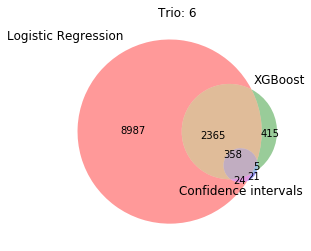

Trio: 15_
Total positions: 97120
Recalibrated % (all methods): 1.62


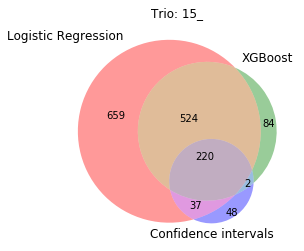

Trio: Kr_
Total positions: 94710
Recalibrated % (all methods): 3.72


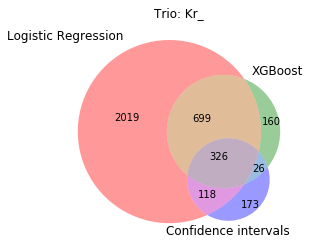

In [2]:
for prefix, vcf_path in zip(['6', '15_', 'Kr_'],
                            ['6.gencode27withflank50.vcf',
                             '15.gencode27withflank50.vcf',
                             'Kr.hg19.gencode27withflank50.vcf']):

    ab = VCF("../data/" + vcf_path)
    ab_ci = VCF(prefix + "recalibrated_ci.vcf")
    ab_lr = VCF(prefix + "recalibrated_lr.vcf")
    ab_xgb = VCF(prefix + "recalibrated_xgb.vcf")

    for abortus in [ab, ab_lr, ab_xgb, ab_ci]:
        abortus.process(0.04120035307396641, prefix + "mo", prefix + "fa", prefix + "ab")

    lr = ab.df_processed[prefix + 'ab^GT'].values != ab_lr.df_processed[prefix + 'ab^GT'].values
    xgb = ab.df_processed[prefix + 'ab^GT'].values != ab_xgb.df_processed[prefix + 'ab^GT'].values
    ci = ab.df_processed[prefix + 'ab^GT'].values != ab_ci.df_processed[prefix + 'ab^GT'].values

    recal = np.logical_or(np.logical_or(lr, xgb), ci)
    recal_all = np.logical_and(np.logical_and(lr, xgb), ci)
    
    print("Trio: {}".format(prefix))
    print("Total positions: {}".format(len(recal)))
    print("Recalibrated % (all methods): {:.2f}".format(np.sum(recal)/len(recal)*100))
    
    plt.figure()
    plt.title("Trio: {}".format(prefix))
    venn3([np.sum(arr) for arr in [np.logical_and(lr, ~(np.logical_or(xgb, ci))),
                                   np.logical_and(xgb, ~(np.logical_or(lr, ci))),
                                   np.logical_and(~recal_all, np.logical_and(lr, xgb)),
                                   np.logical_and(ci, ~(np.logical_or(lr, xgb))),
                                   np.logical_and(~recal_all, np.logical_and(ci, lr)),
                                   np.logical_and(~recal_all, np.logical_and(ci, xgb)),
                                   recal_all]],
     ("Logistic Regression", "XGBoost", "Confidence intervals")
    )
    plt.show()